In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from keras import models, optimizers, backend
from keras.layers import core, convolutional, pooling
from sklearn import model_selection
import cv2
import random

from tensorflow.keras.utils import Sequence
import matplotlib.image as mpimg

import json
import matplotlib.pyplot as plt

from PIL import Image
import skimage 
from skimage.transform import resize

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder


from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from lime import lime_image

from keras.applications import inception_v3 as inc_net
from keras.applications.imagenet_utils import decode_predictions




In [2]:
dataset = ('C:/Users/Ketan/Thesis/self-driving-car/challenges/resized_dataset_udacity_320x240')

In [3]:
# Read the data
df = pd.io.parsers.read_csv(os.path.join(dataset, 'out.csv'))
# # Split data into training and validation sets
df_train, df_valid = model_selection.train_test_split(df, test_size=.2)

In [4]:
pd.options.mode.chained_assignment = None #default = warn

In [5]:
df_train['angle_range'] = pd.qcut(df_train['angle'], q=10)
df_valid['angle_range'] = pd.qcut(df_valid['angle'], q=10)

In [6]:
df_train['labels']= df_train['angle_range'].cat.codes
df_valid['labels']= df_valid['angle_range'].cat.codes

In [7]:
df_train['labels'] = df_train['labels'].apply(str)
df_valid['labels'] = df_valid['labels'].apply(str)


In [13]:
datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=df_train, directory=dataset, x_col="File", y_col="labels", 
                                            class_mode="categorical", target_size=(240,320), batch_size=32, shuffle = True)

Found 4491 validated image filenames belonging to 10 classes.


In [14]:
valid_generator=datagen.flow_from_dataframe(dataframe=df_valid, directory=dataset, 
                                            x_col="File", y_col="labels", class_mode="categorical", target_size=(240,320), 
                                            batch_size=32, shuffle = True)

Found 1123 validated image filenames belonging to 10 classes.


In [15]:
model = models.Sequential()
model.add(convolutional.Convolution2D(16,3,3, input_shape=(240,320,3), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(convolutional.Convolution2D(32, 3, 3, activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(convolutional.Convolution2D(64, 3, 3, activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(core.Flatten())
model.add(core.Dense(500, activation='relu'))
model.add(core.Dropout(.5))
model.add(core.Dense(100, activation='relu'))
model.add(core.Dropout(.25))
model.add(core.Dense(20, activation='relu'))
model.add(core.Dense(10, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), loss='categorical_crossentropy',metrics=['AUC', 'categorical_accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 80, 106, 16)       448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 40, 53, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 9, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 3, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [19]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs_classification_resized1', histogram_freq=0,
                          write_graph=True, write_images=False)

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [21]:
checkpoint_filepath = './logs_classification_resized1'
callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=0, 
                                               save_best_only=False, save_weights_only=False, mode='auto', 
                                               save_freq='epoch',options=None)

In [22]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=44, callbacks=[callback, callback1, tensorboard])

C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/44
140/140 [==============================] - 72s 420ms/step - loss: 2.3026 - auc: 0.5070 - categorical_accuracy: 0.1070 - val_loss: 2.2994 - val_auc: 0.5247 - val_categorical_accuracy: 0.1464
INFO:tensorflow:Assets written to: .\logs_classification_resized1\assets
Epoch 2/44
140/140 [==============================] - 50s 358ms/step - loss: 2.2992 - auc: 0.5215 - categorical_accuracy: 0.1135 - val_loss: 2.2926 - val_auc: 0.5651 - val_categorical_accuracy: 0.1813
INFO:tensorflow:Assets written to: .\logs_classification_resized1\assets
Epoch 3/44
140/140 [==============================] - 51s 361ms/step - loss: 2.2907 - auc: 0.5519 - categorical_accuracy: 0.1334 - val_loss: 2.2777 - val_auc: 0.5926 - val_categorical_accuracy: 0.1804
INFO:tensorflow:Assets written to: .\logs_classification_resized1\assets
Epoch 4/44
140/140 [==============================] - 50s 359ms/step - loss: 2.2675 - auc: 0.5901 - categorical_accuracy: 0.1543 - val_loss: 2.2390 - val_auc: 0.6385 - val_catego

Epoch 31/44
140/140 [==============================] - 51s 363ms/step - loss: 0.7616 - auc: 0.9676 - categorical_accuracy: 0.7331 - val_loss: 0.9414 - val_auc: 0.9490 - val_categorical_accuracy: 0.6625
INFO:tensorflow:Assets written to: .\logs_classification_resized1\assets
Epoch 32/44
140/140 [==============================] - 51s 364ms/step - loss: 0.7309 - auc: 0.9704 - categorical_accuracy: 0.7405 - val_loss: 0.9062 - val_auc: 0.9526 - val_categorical_accuracy: 0.6804
INFO:tensorflow:Assets written to: .\logs_classification_resized1\assets
Epoch 33/44
140/140 [==============================] - 51s 363ms/step - loss: 0.6904 - auc: 0.9739 - categorical_accuracy: 0.7526 - val_loss: 0.8967 - val_auc: 0.9531 - val_categorical_accuracy: 0.6812
INFO:tensorflow:Assets written to: .\logs_classification_resized1\assets
Epoch 34/44
140/140 [==============================] - 53s 375ms/step - loss: 0.6713 - auc: 0.9750 - categorical_accuracy: 0.7587 - val_loss: 0.8678 - val_auc: 0.9561 - val_ca

In [78]:
test_acc = model.evaluate_generator(valid_generator)

C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [110]:
print("%s%s: %.2f%%" % ("evaluate_generator ",model.metrics_names[2], test_acc[1]*100))


evaluate_generator categorical_accuracy: 95.79%


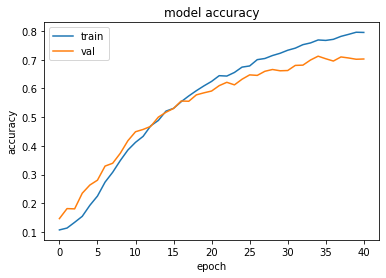

In [30]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.show()
plt.savefig('C:/Users/Ketan/Thesis/self-driving-car/challenges/model_accuracy_classification_resized.jpg', dpi=300)

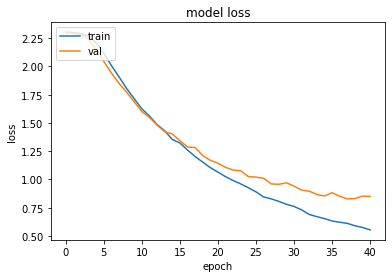

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('C:/Users/Ketan/Thesis/self-driving-car/challenges/model_loss_classification_resized.jpg', dpi=300)

In [93]:
# model.save_weights('udacity_classification_custom_model_weights_v3.h5')

In [26]:
model.save('udacity_classification_custom_model_resized1_v1.h5')

In [114]:
preds = model.predict(valid_generator, steps = STEP_SIZE_VALID)

In [115]:
predicted_classes = np.argmax(preds, axis=1)


In [116]:
predicted_classes.shape

(1123,)

In [117]:
true_classes = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())   

In [118]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

           0       0.11      0.13      0.12       113
           1       0.12      0.10      0.11       112
           2       0.15      0.18      0.16       112
           3       0.10      0.08      0.09       119
           4       0.06      0.08      0.07       106
           5       0.07      0.09      0.08       114
           6       0.16      0.15      0.16       110
           7       0.08      0.07      0.08       112
           8       0.16      0.14      0.15       112
           9       0.12      0.09      0.10       113

    accuracy                           0.11      1123
   macro avg       0.11      0.11      0.11      1123
weighted avg       0.11      0.11      0.11      1123



In [90]:
len(true_classes)

1123

In [76]:
y_pred1 = np.argmax(preds1, axis=1)

In [61]:
# ypred = preds.argmax(axis=-1)
y_pred = np.argmax(preds, axis=1)

In [71]:
target = ['0','1','2','3','4','5','6','7','8','9']


In [74]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(valid_generator.classes, y_pred))


[[13  9 20 11 10  9 10 14 12  5]
 [ 6 12 14  8 18 16 10  9  7 12]
 [12  5 13  8 10 21 12  8 12 11]
 [18  9 16 11 13 12 12  9 10  9]
 [16 10 12  5 14 13  8  9 12  7]
 [14 11 12 10 14 15 13 10  5 10]
 [10  7 13  7 13 18 10 14 10  8]
 [11  8 10  6 13 17 13  9 15 10]
 [18 12  9 13 16  8 12  9  9  6]
 [13 12 14  9 18 11  9  9 11  7]]


In [67]:
print(classification_report(valid_generator.classes, y_pred, target_names=target))


              precision    recall  f1-score   support

           0       0.10      0.12      0.11       113
           1       0.12      0.10      0.11       112
           2       0.09      0.11      0.10       112
           3       0.16      0.12      0.14       119
           4       0.11      0.14      0.12       106
           5       0.07      0.09      0.08       114
           6       0.09      0.09      0.09       110
           7       0.11      0.10      0.10       112
           8       0.05      0.04      0.05       112
           9       0.09      0.07      0.08       113

    accuracy                           0.10      1123
   macro avg       0.10      0.10      0.10      1123
weighted avg       0.10      0.10      0.10      1123



C:\Users\Ketan\anaconda3\envs\tf-gpu-cuda\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


36/36 [==============================] - 10s 289ms/step


0.5004432032148396

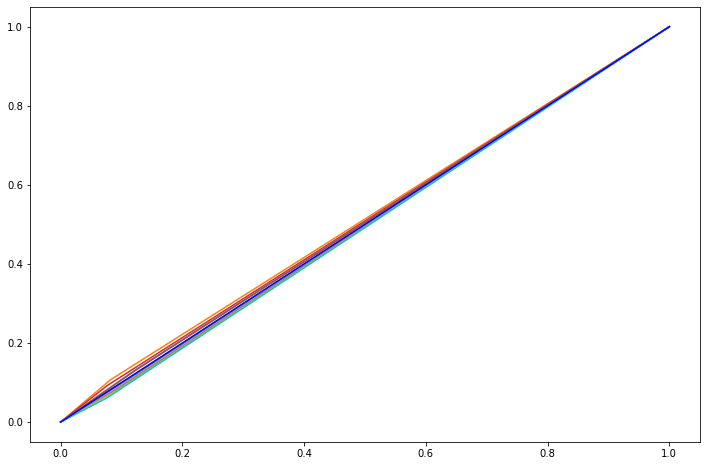

In [69]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
valid_generator.reset() # resetting generator
y_pred = model.predict_generator(valid_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(valid_generator.classes, y_pred)

In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


In [70]:
# target = ['0','1','2','3','4','5','6','7','8','9']
# fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# # function for scoring roc auc score for multi-class
# def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
#     lb = LabelBinarizer()
#     lb.fit(y_test)
#     y_test = lb.transform(y_test)
#     y_pred = lb.transform(y_pred)

#     for (idx, c_label) in enumerate(target):
#         fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
#         c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
#     c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
#     return roc_auc_score(y_test, y_pred, average=average)


# print('ROC AUC score:', multiclass_roc_auc_score(train_generator, ypred))

# c_ax.legend()
# c_ax.set_xlabel('False Positive Rate')
# c_ax.set_ylabel('True Positive Rate')
# plt.show()

In [53]:
model1 = models.load_model('C:/Users/Ketan/Thesis/self-driving-car/challenges/tl_regression_resized_udacity_v4.h5', compile=False)


In [25]:
from keras.applications import inception_v3 as inc_net


In [26]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img((img_path), target_size=(480,640))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out) /2 +0.5

In [27]:
images = transform_img_fn([os.path.join(r'C:/Users/Ketan/Thesis/self-driving-car/challenges/challenge-2/','1479425717280900950.jpg')])


In [28]:
model.predict(images)

array([[2.7272626e-04, 9.8335797e-01, 1.0109666e-02, 1.5271852e-03,
        1.8140408e-03, 1.4903632e-03, 1.4183132e-03, 4.0885689e-06,
        1.9641282e-06, 3.6494907e-06]], dtype=float32)

In [54]:
 def open_images(inference_folder: str) -> np.ndarray:
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  # create full path to image

        with Image.open(img_location) as img:  # open image with pillow

            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net
            img = inc_net.preprocess_input(img)

        images.append(img)
    images_array = np.vstack(images)/2+0.5  # combine images efficiently to a numpy array
    return images_array

In [55]:
images = open_images("C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2")


In [57]:
predictions = model1.predict_generator(images)
images_names = os.listdir("C:/Users/Ketan/Thesis/self-driving-car/challenges/test_dataset2")
for image_name, prediction in zip(images_names, predictions):
    print(image_name, prediction)

1479425442432797491.jpg [0.0312406]
1479425442482899263.jpg [0.07867743]
1479425442532771570.jpg [0.06185395]
1479425442582809345.jpg [0.02647948]
1479425442632821093.jpg [-0.03689958]
1479425442682747552.jpg [-0.02785037]
1479425442732806572.jpg [-0.01831637]
1479425442782862182.jpg [-0.02136489]
1479425442832833025.jpg [0.02257168]
1479425442882822631.jpg [0.02476405]
1479425442932809867.jpg [0.07196597]
1479425477788948138.jpg [-0.10604262]
1479425477838934577.jpg [-0.13396217]


In [58]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 120, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 120, 160, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________